In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/barc-intern-1/OdettedataML1.csv
/kaggle/input/barc-intern-1/japan2.csv
/kaggle/input/barc-intern-1/final data.csv


In [17]:
!pip install pycaret -q

In [ ]:
import numpy as np
import pandas as pd
from pycaret.regression import *
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])
from sklearn import set_config
set_config(display='text')
import optuna
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
from datetime import datetime


In [20]:
df3 = pd.read_csv("/kaggle/input/barc-intern-1/final data.csv")

# Drop the target column to prepare for normalization
df4 = df3.drop('DeltaT', axis=1)

In [ ]:
# Normalize the features
df_norm2 = (df4 - df4.min()) / (df4.max() - df4.min())
df_norm2 = pd.concat((df_norm2, df3.DeltaT), axis=1)


In [ ]:

# Display the correlation matrix
correlation_matrix = df3.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.savefig('correlation_matrix.png')

In [ ]:
# Set up PyCaret with cross-validation
# Using 5-fold cross-validation to ensure robust model evaluation
reg_setup = setup(data=df_norm2, target='DeltaT', session_id=123, 
                 normalize=False,  # Already normalized
                 train_size=0.8,
                 fold=5,  # 5-fold cross-validation
                 verbose=False)

In [ ]:
best_model = compare_models(sort='R2', n_select=1, verbose=True)


In [ ]:
# Tune the best model to improve R2 score
tuned_model = tune_model(best_model, 
                        optimize='R2', 
                        n_iter=50,  # Increase iterations for better tuning
                        verbose=True)

In [ ]:
# Finalize the tuned model
final_model = finalize_model(tuned_model)

# Make predictions on the hold-out test set
predictions = predict_model(final_model)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,6.6003,88.5477,9.3381,0.8707,0.4539,0.4113,0.4920
gbr,Gradient Boosting Regressor,7.4613,102.1118,10.0543,0.8522,0.4753,0.4409,0.0540
et,Extra Trees Regressor,6.5338,102.1861,9.9975,0.8505,0.4641,0.3993,0.0980
rf,Random Forest Regressor,7.7610,114.7786,10.6077,0.8334,0.4836,0.4562,0.1320
xgboost,Extreme Gradient Boosting,6.9468,117.2842,10.6930,0.8292,0.4890,0.4062,0.0540
ada,AdaBoost Regressor,9.4621,138.6055,11.7405,0.7997,0.5344,0.5831,0.0660
lightgbm,Light Gradient Boosting Machine,9.1901,159.3089,12.5694,0.7718,0.5116,0.4877,3.9700
dt,Decision Tree Regressor,8.3263,160.9393,12.3483,0.7617,0.5725,0.4534,0.0160
lar,Least Angle Regression,10.7447,186.5925,13.5982,0.7321,0.5995,0.5939,0.0160
lr,Linear Regression,10.7447,186.5925,13.5982,0.7321,0.5995,0.5939,1.4200


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.0846,87.6591,9.3626,0.8950,0.3905,0.4015
1,5.7590,90.3195,9.5037,0.8820,0.4588,0.6090
2,4.7697,48.0254,6.9300,0.9354,0.4517,0.1977
3,5.7764,80.4363,8.9686,0.8619,0.6005,0.4092
4,7.5112,131.8362,11.4820,0.7886,0.3162,0.3202
Mean,6.1802,87.6553,9.2494,0.8726,0.4435,0.3875
Std,0.9919,26.7645,1.4505,0.0484,0.0938,0.1344


Fitting 5 folds for each of 50 candidates, totalling 250 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.8705,1.8939,1.3762,0.9981,0.1634,0.0647


Final R2 Score on Test Set: 0.9980954370566556
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Cu', 'Ni', 'P', 'Fluence',
                                              'Tirr'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('actual_estimator',
                  <catboost.core.CatBoostRegressor object at 0x7e895c2a7090>)]),
 'best_temperature_prediction_model.pkl')

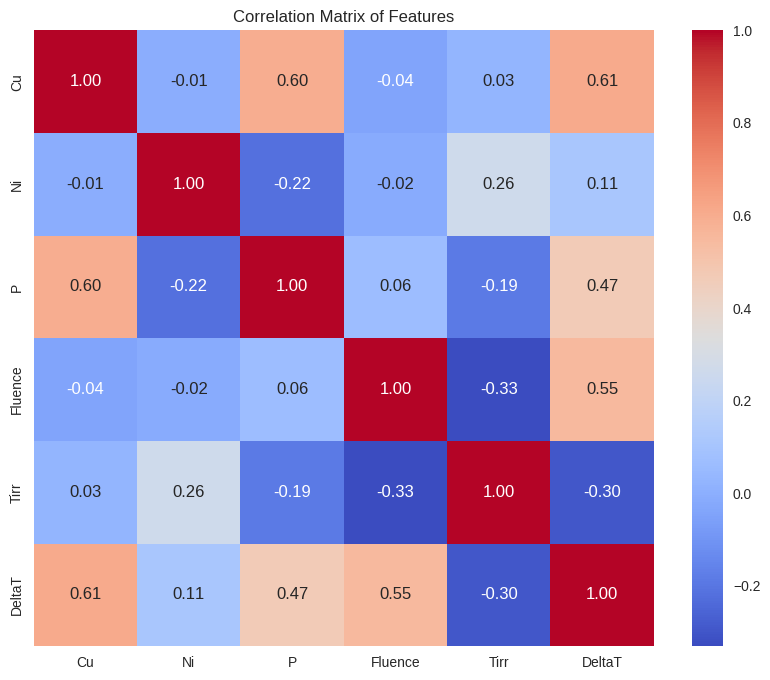

In [18]:
# Calculate and print the R2 score on the test set
y_test = predictions['DeltaT']
y_pred = predictions['prediction_label']
final_r2_score = r2_score(y_test, y_pred)
print(f"Final R2 Score on Test Set: {final_r2_score}")

# Save the model for future use
save_model(final_model, 'best_temperature_prediction_model')

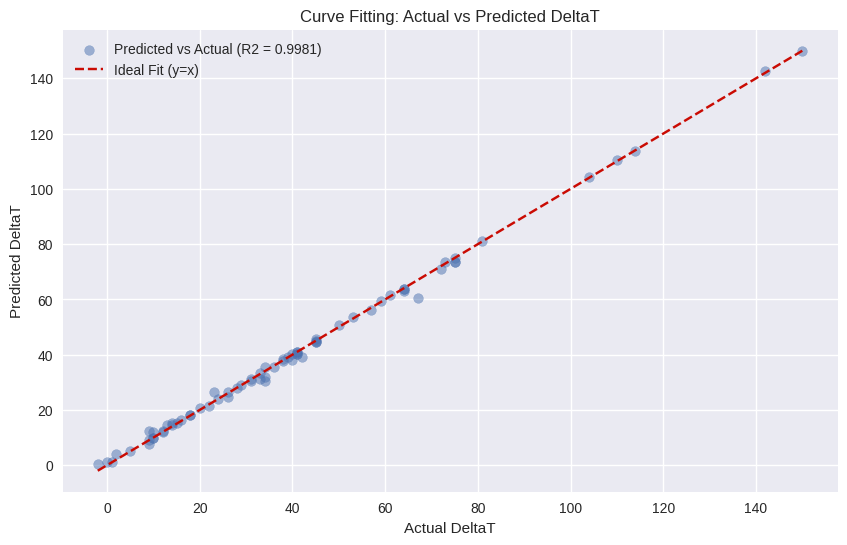

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label=f'Predicted vs Actual (R2 = {final_r2_score:.4f})')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit (y=x)')
plt.xlabel('Actual DeltaT')
plt.ylabel('Predicted DeltaT')
plt.title('Curve Fitting: Actual vs Predicted DeltaT')
plt.legend()
plt.grid(True)
plt.savefig('curve_fitting.png')

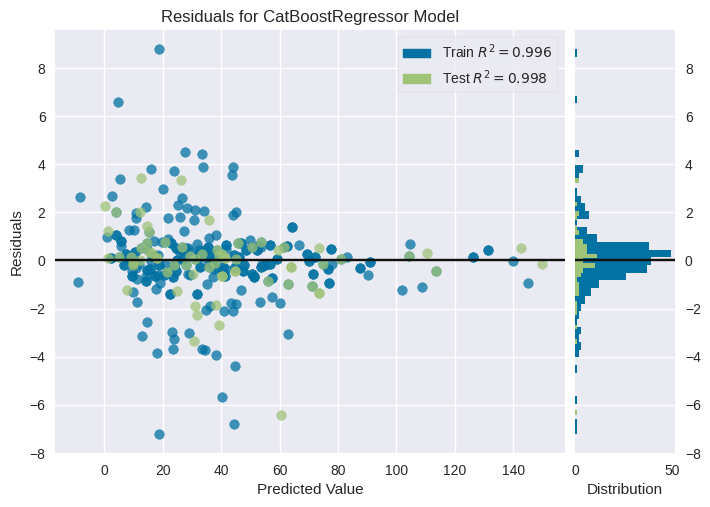

In [19]:
plot_model(final_model)

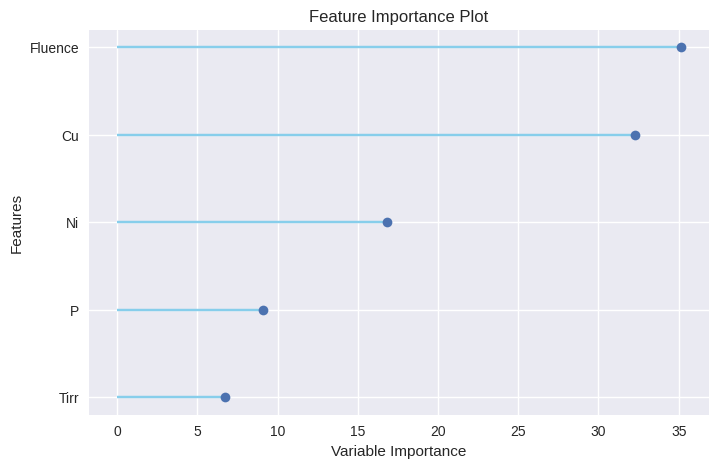

In [23]:
plot_model(best_model, plot = 'feature')


In [24]:
!pip install shap -q

In [25]:
import shap
pd.set_option('display.max_columns', None)
shap.initjs()


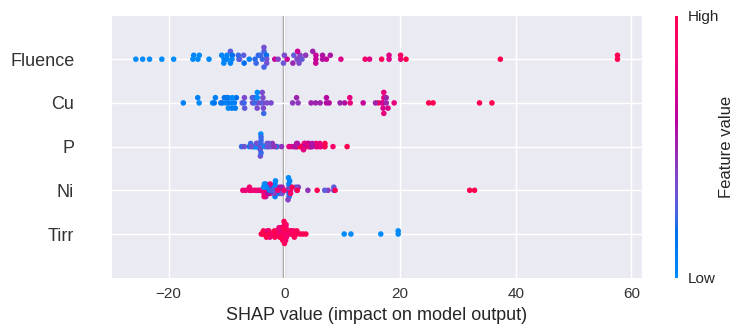

In [28]:
interpret_model(best_model, plot = 'summary')
